# Sending the packets

## Broadcast case:

A raspberry pi is broadcasting packets which payloads consist on just 0 bits

The code for broadcasting is;

```python
# Send UDP broadcast packets

MYPORT = 53524

import sys, time, array
from socket import *

s = socket(AF_INET, SOCK_DGRAM)
s.bind(('', 0))
s.setsockopt(SOL_SOCKET, SO_BROADCAST, 1)

while 1:
    #data = repr(time.time()) + '\n'
    data = "0"*100
    data= data.decode('hex')
    s.sendto(data, ('<broadcast>', MYPORT))
    print data
    time.sleep(0.1)
```

# Capturing the packets

To capture the packets it is needed to set the NIC in monitor mode. The instructions are [here](https://sandilands.info/sgordon/capturing-wifi-in-monitor-mode-with-iw)

## Setting up the monitor interface

The only special consideration is that you need to include the flag for capturing packets with the FCS fail:

```bash
sudo iw phy phy0 interface add mon0 type monitor flags fcsfail
```

I do the following when using the USB dongle

```bash
sudo iw phy phy1 interface add mon0 type monitor flags fcsfail
sudo iw dev wlp0s26u1u2 del
sudo ifconfig mon0 up
# Set it to channel 6
sudo iw dev mon0 set freq 2437
```

### Troubleshooting: type doesn't change to monitor from managed

If the type does not change, it is most likely because network manager is controlling the interface. For solving this, one must remove the interface from the `/etc/NetworkManager/NetworkManager.conf` file.

Add these lines to said file:

```
[main]
plugins=keyfile

[keyfile]
unmanaged-devices=mac:xx:xx:xx:xx:xx:xx
```

The correct MAC address can be found running the command `iw dev`

## Tshark for packet capturing

The script used for capturing the packets is the following
```bash
if [ "$#" -ne 2 ]; then
    echo "Input the mw and the data rate as arguments"
    echo "Usage: ./capture.sh xx yy"
    echo "xx: mw"
    echo "yy: mbps"
    exit 1
fi

tshark -i mon0 -f "udp && host 192.168.1.144 && port 53524" \
    -w "$(date +%F_%H_%M)_$1mw_$2mbps.pcapng" -T fields -E separator=' ; ' \
    -e wlan.fcs_bad -e radiotap.dbm_antsignal
```

* -i interface
* -f is the capture filter (we only want to capture the UDP packets sent from the raspi)
* -w name of the output file
* -T We want to display some packets fields in console
* -e specify which fields (fcs broken and signal strength in dBm)

# Analyzing the data

In [32]:
import pyshark
import pandas as pd
import matplotlib.pyplot as plt
# import binascii
import timeit
import os

Some constants

In [2]:
TOTAL_BITS = 400
AP_MAC = '58:6d:8f:d3:5e:70'

In [3]:
# See the plots in Jupyter env
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Loading the captured packets

In [20]:
# file = 'test_capture.pcapng'
# file = 'gvsp.pcapng'
# file = 'bigger test.pcapng'
# file = 'test_for_weekend.pcapng'
# file = '30-11-15_54mbps_1mw.pcapng'
# file = '2015-12-04_17_25.pcapng' # Testing automated measurements
file = '2015-12-07_11_51.pcapng' # Test across the rooms


cap = pyshark.FileCapture(file)

## Extracting information

### Filter the CRC broken packets

In [5]:
# Lets measure the time it takes to complete this
start_time = timeit.default_timer()

broken_pkts = [pkt for pkt in cap if pkt.wlan.fcs_bad == '1']

print ('Time taken: {} seconds'.format(timeit.default_timer() - start_time))

total_broken_pkts = len(broken_pkts)

Time taken: 256.65003561000003 seconds


#### Make a dataframe with all the files

In [ ]:
file_list = ['2015-12-07_16_31_60mw_1mbps.pcapng', '2015-12-07_17_04_60mw_9mbps.pcapng',
             '2015-12-07_17_36_60mw_18mbps.pcapng', '2015-12-07_18_11_60mw_36mbps.pcapng',
             '2015-12-07_18_55_60mw_54mbps.pcapng']

start_time = timeit.default_timer()

broken_pkts = []
for pcap in file_list:
    print("reading file: " + pcap)
    cap = pyshark.FileCapture(pcap)
    for pkt in cap:
        if pkt.wlan.fcs_bad == '1':
            broken_pkts.append(pkt)

print ('Time taken: {} seconds'.format(timeit.default_timer() - start_time))

total_broken_pkts = len(broken_pkts)

reading file: 2015-12-07_16_31_60mw_1mbps.pcapng
reading file: 2015-12-07_17_04_60mw_9mbps.pcapng

We use pandas to build the data frame with some usefull columns:

In [ ]:
# Broken data as a string
data = []
data_rate = []
rssi = []
tx_mac = []
is_broken = []
for pkt in broken_pkts:
# for pkt in pkts:
    # Data
    try:
        data.append(pkt.data.data)
    except(AttributeError):
        continue
    # Data rate
    try:
        data_rate.append(pkt.radiotap.datarate)
    except:
        data.pop()
        continue
    # RSSI
    try:
        rssi.append(pkt.radiotap.dbm_antsignal)
    except:
        data.pop()
        data_rate.pop()
        continue
    # Transmitter MAC Address
    try:
        tx_mac.append(pkt.wlan.ta)
    except:
        data.pop()
        data_rate.pop()
        rssi.pop()
        continue
    # CRC failed
    try:
        is_broken.append(bool(pkt.wlan.fcs_bad))
    except:
        data.pop()
        data_rate.pop()
        rssi.pop()
        tx_mac.pop()
        continue

fields={'Data':data,'Data_rate':data_rate,'RSSI':rssi,'Tx_mac':tx_mac,'Broken':is_broken}
p_data = pd.DataFrame(fields)
# ==========

# Add a column stating if the AP sent the packet
p_data['AP_pkt'] = p_data['Tx_mac'].apply(lambda x: x == '58:6d:8f:d3:5e:70')
# ==========

# Add a column stating if the data has the right length
p_data['Right_Length'] = p_data['Data'].apply(lambda x: len(x) == 100)
# ==========

# Add a column with Binary Data
def str2bin(number):
    decimal_number = int(number,16)
    # Do not return the '0b' at the beginning and fill with zeroes
    return bin(decimal_number)[2:].zfill(8)

def data_to_bin(data):
    return [str2bin(data[byte : byte+2]) for byte in range(0, len(data),2)]

def bytes_to_binarray(list_of_bytes):
    temp_str = ''
    for byte in list_of_bytes:
        temp_str = temp_str + byte
    return temp_str

p_data['Data_bin'] = p_data['Data'].apply(data_to_bin)
p_data['Data_bin'] = p_data['Data_bin'].apply(bytes_to_binarray)
# ==========

# Add column with number of bits flipped
p_data['Flipped_bits'] = p_data['Data_bin'].apply(lambda x: x.count('1'))
# ==========

Count the number of packets with the right and wrong length

In [8]:
# Group the packets in right/wrong length and count the number of occurences
lengths = p_data.groupby(['Right_Length']).size()

# Right length
total_broken_pkts_true_length = lengths[True]

# Wrong length
total_broken_pkts_false_length = lengths[False]

### Percentage of broken packets

In [71]:
# Total packets captured sent from the AP
# We get this number doing a system call to tshark: tshark -r 2015-12-07_11_51.pcapng -Y 'wlan.ta==58:6d:8f:d3:5e:70 && wlan.fcs_bad==true' | wc -l
command = 'tshark -r ' + file + ' -Y \'wlan.ta==' + AP_MAC + '\' | wc -l'
total_pkts_AP = np.int64(os.popen(command).read())

# Percentage of useful broken packets. I.e., *Sent from AP; *Correct length; *IP from Raspi (@capture time); *Right port (@capture time)
total_useful_broken_packets = np.int64(len(p_data[(p_data['Right_Length'] == True) &(p_data['AP_pkt'] == True)].index))
percentage_broken_pkts = total_useful_broken_packets / total_pkts_AP *100

print ("Percentage of broken packets = {}".format(percentage_broken_pkts))

Percentage of broken packets = 16.504552980132452


## Bits flipped

Create a vector containing the number of bits flipped in specific locations

In [9]:
# Empty vector
flips_occurences = [0]*TOTAL_BITS

# Operate only over data packets of the right size
right_size_data = p_data[p_data['Right_Length'] == True]['Data_bin']

for row in right_size_data:
    # Traverse the vector
    for i,x in enumerate(row):
        # If the value is a '1' add one to the vector of flips_occurences
        if x == '1':
            flips_occurences[i] = flips_occurences[i] + 1

Plot the histogram with flip ocurrences

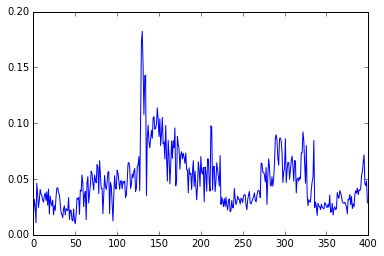

In [72]:
fig = plt.figure()
plt.plot(range(len(flips_occurences)),flips_occurences / total_useful_broken_packets)

### Average number of flipped bits

In [12]:
p_data[p_data['Right_Length'] == True]['Flipped_bits'].mean()

16.43573247553947

# =========================================================
### Cells for testing code
# =========================================================

In [61]:
p_data[(p_data['Right_Length'] == True) &(p_data['AP_pkt'] == False)]

Broken                                               Data Data_rate RSSI  \
2      True  0000000000000000000000000000000000000000000000...        54  -71   
4      True  00000000000000000000a098135a237324000000000000...        54  -74   
19     True  09f300000000000000de15f3d3f3bb4600000000000000...        54  -73   
23     True  0000000000608e39bd1b092ae684d6c862e6effa010000...        54  -69   
30     True  0000000000000000000000000000000000000000000000...        54  -71   
38     True  c800000000000000000000000000000000000000000000...        54  -73   
39     True  000000000000004ed0c81c496800000000000000000000...        54  -73   
51     True  0000000000000000000000000000000000000000000000...        54  -73   
52     True  0000000000000000000000604e4c50313f000000600ef3...        54  -73   
57     True  0000000000000000000000000000000000000000000000...        54  -73   
59     True  0000000000000000000000000000000000000000000000...        54  -72   
68     True  0000000000000000000000000000000000000000000000...        54  -72   
71     True  0000000000000000000000000000000000000000000000...        54  -72   
83     True  000000000000000000000000000000000000000000c01c...        54  -73   
85     True  0000000000000000000000000000000000000000000000...        54  -72   
87     True  0000000000000000000000e00400000000000000000000...        54  -72   
97     True  0000000000000000000000000000000000000000000000...        54  -73   
99     True  0000000000000000000000000000000000000000000000...        54  -73   
100    True  0000000000000000000000000000000000000000000000...        54  -72   
106    True  0000000000000000000000000000000000000000000000...        54  -72   
107    True  0000000000000000000000000000000000000000000000...        54  -73   
114    True  00000000000000000000000000000000e6000000000000...        54  -72   
131    True  0000000000000000000000000000000000000000000000...        54  -73   
133    True  0000000000000000000000000000000000000000000000...        54  -72   
134    True  0000000000000000000000000000000000000000000000...        54  -71   
140    True  0000000000000000000000000000000000000000000000...        54  -73   
173    True  0000000000000000000000000000000000000000000000...        54  -73   
177    True  0000000000000000000000000000000000000000000000...        54  -74   
199    True  000000000000000040654f300cf3dbc81ca112fa010000...        54  -72   
205    True  0000000000000000000000000000000000000000000000...        54  -72   
...     ...                                                ...       ...  ...   
8544   True  0000000000000000000000000000000000000000000000...        54  -72   
8545   True  0000000000000000000000000000000000000000000000...        54  -72   
8548   True  0000000000000000000000000000000000000000000000...        54  -70   
8550   True  0000000000000000000000000000000000000000000000...        54  -73   
8570   True  000000000000007e970000000000000000000000000000...        54  -73   
8575   True  0000000000000000000000000000000000000000000000...        54  -69   
8580   True  0000000000000000000000e00400000000000000000000...        54  -69   
8588   True  00000000000000a8980d00000000000000000000000000...        54  -72   
8608   True  0000000000000000000000000000000000000000000000...        54  -69   
8609   True  d7ef020000000000000000000000000000000000608ed0...        54  -71   
8610   True  0000000000000000000000000000000000000000000000...        54  -72   
8611   True  0000000000000000000000000000000000000000000000...        54  -71   
8617   True  0000000000000000000000000000000000000000000000...        54  -71   
8619   True  0000000000000000000000000000000000000000000000...        54  -70   
8625   True  0000000000000000000000000000000000000000000000...        54  -70   
8636   True  0000000000000000000000000000000054cc1bd930bf91...        54  -70   
8657   True  0000000000000000000000000000000000000000000000...        54  -73   
8683   True  00000000000000000000000

In [ ]:
# cap2 = pyshark.FileCapture('big test.pcapng',display_filter='wlan.fcs_bad == true')


In [ ]:
rr = p_data[p_data['Right_Length'] == True]
rr.shape
total_broken_pkts_true_length

In [ ]:
# Broken data as a string
# p_data = pd.DataFrame([pkt.data.data for pkt in broken_pkts], columns=['Data'])
data=[]
for pkt in broken_pkts:
    try:
        data.append(pkt.data.data)
    except:
        continue
len(data)
p_data = pd.DataFrame(data,columns=['Data'])
p_data

# =========================================================
### Deprecated
# =========================================================

Get the broken data from the packets as a string, hex values and binary array <span style="color:red;">(Deprecated, it's done with Pandas now)</span> 

In [ ]:
# # Broken data as a string
# broken_data = [pkt.data.data for pkt in broken_pkts]


# # filter out packets that have the wrong data length
# broken_data = [x for x in broken_data if len(x) == 100]
# total_broken_pkts_true_length = len(broken_data)
# total_broken_pkts_false_length = total_broken_pkts - total_broken_pkts_true_length

# # # Broken data as hex values
# # hex_broken_data=[]
# # count = 0
# # for data in broken_data:
# #     hex_broken_data.append([binascii.a2b_hex(data[byte:byte+2]) for byte in range(0, len(data),2)])
# #     #print(byte)
# #     count=count+1
    
# # Broken data as binary values
# def str2bin(number):
#     decimal_number = int(number,16)
#     # Do not return the '0b' at the beginning and fill with zeroes
#     return bin(decimal_number)[2:].zfill(8)
# bin_broken_data = []
# for data in broken_data:
#     bin_broken_data.append([str2bin(data[byte : byte+2]) for byte in range(0, len(data),2)])




Build a single array of bits per broken data  <span style="color:red;">(Deprecated, it's done with Pandas now)</span> 

In [ ]:
# temp = []
# temp_str = ''
# for data in bin_broken_data:
#     for byte in data:
#         temp_str = temp_str + byte
#     temp.append(temp_str)
#     temp_str=''

# bin_broken_data = temp
    